<a href="https://colab.research.google.com/github/Adil1979/P6_Tag_Recommendation_Stackoverflow/blob/master/01_P6_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet6: Catégorisation automatique de questions**

## **1.Librairies**

In [192]:
!pip install feature_engine


In [193]:
!pip install plotly

In [194]:
!pip install chart-studio

In [195]:
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib as mpl
import chart_studio.plotly.plotly as py
from collections import Counter
#import plotly.plotly as py
import seaborn as sns
import datetime as dt
import calendar as cld
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from os import listdir
import glob
import missingno as msno
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from sklearn.decomposition import PCA
from matplotlib import dates
import nltk
import re
from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
import string
from collections import Counter
from bs4 import BeautifulSoup
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SELECT Id, Body, Title, Tags

FROM Posts

WHERE Score >= 3 AND PostTypeId = 1

ORDER BY RAND()
 
ASC OFFSET 0 ROWS FETCH NEXT 50000 ROWS ONLY; de 0 à 50000

## **2.Data**

In [197]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
#df_analysis_01 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_01.csv')
#df_analysis_02 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_02.csv')
#df_analysis_03 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_03.csv')
#frames = [df_analysis_01, df_analysis_02, df_analysis_03]
#df_analysis = pd.concat(frames)
#df_sample = df_analysis.sample(n=40000)
#df_sample.to_csv('df_sample.csv')

In [199]:
df_sample = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/df_sample.csv')
df_sample = df_sample.drop(['Unnamed: 0'], axis=1)
df_sample.head()

,Id,Body,Title,Tags,CreationDate
0,48060830,<p>I am trying to create a very simple system ...,Create System Tray Icon from Webdings font,<c#><.net><windows><icons>,2018-01-02 12:15:37
1,57451083,"<p><a href=""http://eel.is/c++draft/basic.exec#...",Intent of [basic.execution] p5 sentence 2,<c++><language-lawyer><full-expression>,2019-08-11 14:59:51
2,56279423,<p>I use the MongoDB aggregation API to aggreg...,MongoDB: Reduce array of objects into a single...,<mongodb><mongodb-query><aggregation-framework>,2019-05-23 16:24:08
3,48326694,<p>I wonder if its possible to validate a arra...,Laravel validate array of objects,<laravel>,2018-01-18 17:03:31
4,58501086,<p>I am trying to load the save weights using ...,ValueError: Unknown activation function:swish_...,<python><tensorflow><keras><activation-function>,2019-10-22 09:25:59


In [200]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            40000 non-null  int64 
 1   Body          40000 non-null  object
 2   Title         40000 non-null  object
 3   Tags          40000 non-null  object
 4   CreationDate  40000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [201]:
df_sample = df_sample.loc[:, ['Id', 'Title', 'Body', 'Tags']]
df_sample = df_sample.set_index('Id').reset_index(drop=True)
df_sample.head()

,Title,Body,Tags
0,Create System Tray Icon from Webdings font,<p>I am trying to create a very simple system ...,<c#><.net><windows><icons>
1,Intent of [basic.execution] p5 sentence 2,"<p><a href=""http://eel.is/c++draft/basic.exec#...",<c++><language-lawyer><full-expression>
2,MongoDB: Reduce array of objects into a single...,<p>I use the MongoDB aggregation API to aggreg...,<mongodb><mongodb-query><aggregation-framework>
3,Laravel validate array of objects,<p>I wonder if its possible to validate a arra...,<laravel>
4,ValueError: Unknown activation function:swish_...,<p>I am trying to load the save weights using ...,<python><tensorflow><keras><activation-function>


## **3.Preprocessing**

In [202]:
df_sample.duplicated(subset=["Body", "Title"]).sum()

0

In [203]:
example_body = df_sample.Body.iloc[0]

In [204]:
example_body

'<p>I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border.  To do that, we are using the Webdings font.  "n" in Webdings is just a plain circle.</p>\n\n<p>What I\'m currently doing is almost there, but on some PC\'s (yet not all) it ends up having a choppy, ugly black border around it:</p>\n\n<p><a href="https://i.stack.imgur.com/2rwwx.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/2rwwx.png" alt="enter image description here"></a></p>\n\n<p>Here\'s what I\'ve got:</p>\n\n<pre><code>protected static Icon GetTrayIconFromCache(Color statusColor)\n{\n    Bitmap bmp = new Bitmap(16,16);                            \n    Graphics circleGraphic = Graphics.FromImage(bmp);\n    circleGraphic.DrawString("n", new Font("Webdings", 12F, FontStyle.Regular), Brushes.White, -3f, -2f);\n    circleGraphic.DrawString("n", new Font("Webdings", 9F, FontStyle.Regular), new SolidBrush(statusColor), 0f, -1f);\n    Icon ico

In [205]:
example_title = df_sample.Title.iloc[0]

In [206]:
example_title

'Create System Tray Icon from Webdings font'

In [207]:
#Merge Title and Body
df_sample['Title_Body'] = df_sample['Title'] + ' ' + df_sample['Body']

In [208]:
df_sample.head()


,Title,Body,Tags,Title_Body
0,Create System Tray Icon from Webdings font,<p>I am trying to create a very simple system ...,<c#><.net><windows><icons>,Create System Tray Icon from Webdings font <p>...
1,Intent of [basic.execution] p5 sentence 2,"<p><a href=""http://eel.is/c++draft/basic.exec#...",<c++><language-lawyer><full-expression>,Intent of [basic.execution] p5 sentence 2 <p><...
2,MongoDB: Reduce array of objects into a single...,<p>I use the MongoDB aggregation API to aggreg...,<mongodb><mongodb-query><aggregation-framework>,MongoDB: Reduce array of objects into a single...
3,Laravel validate array of objects,<p>I wonder if its possible to validate a arra...,<laravel>,Laravel validate array of objects <p>I wonder ...
4,ValueError: Unknown activation function:swish_...,<p>I am trying to load the save weights using ...,<python><tensorflow><keras><activation-function>,ValueError: Unknown activation function:swish_...


In [209]:
variables_reorganization = ['Title_Body', 'Tags']
df_sample = df_sample[['Title_Body', 'Tags']]

In [210]:
df_sample.head()

,Title_Body,Tags
0,Create System Tray Icon from Webdings font <p>...,<c#><.net><windows><icons>
1,Intent of [basic.execution] p5 sentence 2 <p><...,<c++><language-lawyer><full-expression>
2,MongoDB: Reduce array of objects into a single...,<mongodb><mongodb-query><aggregation-framework>
3,Laravel validate array of objects <p>I wonder ...,<laravel>
4,ValueError: Unknown activation function:swish_...,<python><tensorflow><keras><activation-function>


In [211]:
df_sample.Title_Body.iloc[0]

'Create System Tray Icon from Webdings font <p>I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border.  To do that, we are using the Webdings font.  "n" in Webdings is just a plain circle.</p>\n\n<p>What I\'m currently doing is almost there, but on some PC\'s (yet not all) it ends up having a choppy, ugly black border around it:</p>\n\n<p><a href="https://i.stack.imgur.com/2rwwx.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/2rwwx.png" alt="enter image description here"></a></p>\n\n<p>Here\'s what I\'ve got:</p>\n\n<pre><code>protected static Icon GetTrayIconFromCache(Color statusColor)\n{\n    Bitmap bmp = new Bitmap(16,16);                            \n    Graphics circleGraphic = Graphics.FromImage(bmp);\n    circleGraphic.DrawString("n", new Font("Webdings", 12F, FontStyle.Regular), Brushes.White, -3f, -2f);\n    circleGraphic.DrawString("n", new Font("Webdings", 9F, FontStyle.Regular), new Solid

### **HTML**

In [212]:
#HTML characters removing
def remove_html(body):
  html_regex = re.compile('<.*?>') #Compile regular expresions
  return re.sub(html_regex, ' ', str(body)) # Replace regex by ' '

In [213]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_html)
df_sample.head()

,Title_Body,Tags
0,Create System Tray Icon from Webdings font I ...,<c#><.net><windows><icons>
1,Intent of [basic.execution] p5 sentence 2 [b...,<c++><language-lawyer><full-expression>
2,MongoDB: Reduce array of objects into a single...,<mongodb><mongodb-query><aggregation-framework>
3,Laravel validate array of objects I wonder if...,<laravel>
4,ValueError: Unknown activation function:swish_...,<python><tensorflow><keras><activation-function>


In [214]:
df_sample.Title_Body.iloc[0]

'Create System Tray Icon from Webdings font  I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border.  To do that, we are using the Webdings font.  "n" in Webdings is just a plain circle. \n\n What I\'m currently doing is almost there, but on some PC\'s (yet not all) it ends up having a choppy, ugly black border around it: \n\n     \n\n Here\'s what I\'ve got: \n\n  protected static Icon GetTrayIconFromCache(Color statusColor)\n{\n    Bitmap bmp = new Bitmap(16,16);                            \n    Graphics circleGraphic = Graphics.FromImage(bmp);\n    circleGraphic.DrawString("n", new Font("Webdings", 12F, FontStyle.Regular), Brushes.White, -3f, -2f);\n    circleGraphic.DrawString("n", new Font("Webdings", 9F, FontStyle.Regular), new SolidBrush(statusColor), 0f, -1f);\n    Icon ico = Icon.FromHandle((bmp).GetHicon());\n    return ico;\n}\n  \n\n No matter what I try, I can\'t get rid of those ugly black dots around the 

### **URL**

In [215]:
#URL removing
def remove_url(body):
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  return re.sub(url_regex, ' ', str(body))  

In [216]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_url)
df_sample.head()

,Title_Body,Tags
0,Create System Tray Icon from Webdings font I ...,<c#><.net><windows><icons>
1,Intent of [basic.execution] p5 sentence 2 [b...,<c++><language-lawyer><full-expression>
2,MongoDB: Reduce array of objects into a single...,<mongodb><mongodb-query><aggregation-framework>
3,Laravel validate array of objects I wonder if...,<laravel>
4,ValueError: Unknown activation function:swish_...,<python><tensorflow><keras><activation-function>


In [217]:
df_sample.Title_Body.iloc[0]

'Create System Tray Icon from Webdings font  I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border.  To do that, we are using the Webdings font.  "n" in Webdings is just a plain circle. \n\n What I\'m currently doing is almost there, but on some PC\'s (yet not all) it ends up having a choppy, ugly black border around it: \n\n     \n\n Here\'s what I\'ve got: \n\n  protected static Icon GetTrayIconFromCache(Color statusColor)\n{\n    Bitmap bmp = new Bitmap(16,16);                            \n    Graphics circleGraphic = Graphics.FromImage(bmp);\n    circleGraphic.DrawString("n", new Font("Webdings", 12F, FontStyle.Regular), Brushes.White, -3f, -2f);\n    circleGraphic.DrawString("n", new Font("Webdings", 9F, FontStyle.Regular), new SolidBrush(statusColor), 0f, -1f);\n    Icon ico = Icon.FromHandle((bmp).GetHicon());\n    return ico;\n}\n  \n\n No matter what I try, I can\'t get rid of those ugly black dots around the 

### **Punctuation**

In [218]:
#Punctuation removing
def remove_punc(body):
  clean_text = re.sub(r'[?|!|"|:|=|_|{|}|[|]|-|$|%|^|&|]',r' ',str(body))
  clean_text = re.sub(r'[.|,|)|(|\|/|-|~|`|>|<|*|$|@|;|→]',r' ', clean_text)
  return clean_text

In [219]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_punc)

In [220]:
df_sample.Title_Body.iloc[0]

" Create System Tray Icon from Webdings font  I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border   To do that  we are using the Webdings font    n  in Webdings is just a plain circle  \n\n What I'm currently doing is almost there  but on some PC's  yet not all  it ends up having a choppy  ugly black border around it  \n\n     \n\n Here's what I've got  \n\n  protected static Icon GetTrayIconFromCache Color statusColor \n \n    Bitmap bmp   new Bitmap 16 16                              \n    Graphics circleGraphic   Graphics FromImage bmp  \n    circleGraphic DrawString  n   new Font  Webdings   12F  FontStyle Regular   Brushes White   3f   2f  \n    circleGraphic DrawString  n   new Font  Webdings   9F  FontStyle Regular   new SolidBrush statusColor   0f   1f  \n    Icon ico   Icon FromHandle  bmp  GetHicon    \n    return ico \n \n  \n\n No matter what I try  I can't get rid of those ugly black dots around the outs

### **Other characters**

In [221]:
#All characters removing except letters, numbers 
#Lower
def remove_other(body):
  text = str(body)
  clean_text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
  return clean_text

In [222]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_other)
df_sample.head()

,Title_Body,Tags
0,create system tray icon from webdings font i...,<c#><.net><windows><icons>
1,intent of basic execution p5 sentence 2 ...,<c++><language-lawyer><full-expression>
2,mongodb reduce array of objects into a singl...,<mongodb><mongodb-query><aggregation-framework>
3,laravel validate array of objects i wonder i...,<laravel>
4,valueerror unknown activation function swish...,<python><tensorflow><keras><activation-function>


In [223]:
df_sample.Title_Body.iloc[0]

' create system tray icon from webdings font  i am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border   to do that  we are using the webdings font    n  in webdings is just a plain circle     what i m currently doing is almost there  but on some pc s  yet not all  it ends up having a choppy  ugly black border around it            here s what i ve got      protected static icon gettrayiconfromcache color statuscolor        bitmap bmp   new bitmap 16 16                                   graphics circlegraphic   graphics fromimage bmp       circlegraphic drawstring  n   new font  webdings   12f  fontstyle regular   brushes white   3f   2f       circlegraphic drawstring  n   new font  webdings   9f  fontstyle regular   new solidbrush statuscolor   0f   1f       icon ico   icon fromhandle  bmp  gethicon         return ico         no matter what i try  i can t get rid of those ugly black dots around the outside of the circle  

### **Space**

In [224]:
#Space removing
def remove_space(body):
  return ' '.join(str(body).split()) 

In [225]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_space)

In [226]:
df_sample.Title_Body.iloc[0]

'create system tray icon from webdings font i am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border to do that we are using the webdings font n in webdings is just a plain circle what i m currently doing is almost there but on some pc s yet not all it ends up having a choppy ugly black border around it here s what i ve got protected static icon gettrayiconfromcache color statuscolor bitmap bmp new bitmap 16 16 graphics circlegraphic graphics fromimage bmp circlegraphic drawstring n new font webdings 12f fontstyle regular brushes white 3f 2f circlegraphic drawstring n new font webdings 9f fontstyle regular new solidbrush statuscolor 0f 1f icon ico icon fromhandle bmp gethicon return ico no matter what i try i can t get rid of those ugly black dots around the outside of the circle they don t show up for everyone some of the developers don t see it and it looks crisp and clean we ve not yet figured out what the commonality 

In [227]:
#df_analysis['Title_Body_count'] = df_analysis['Title_Body'].apply(lambda text: len(text.split(" ")))

In [228]:
df_sample.head()

,Title_Body,Tags
0,create system tray icon from webdings font i a...,<c#><.net><windows><icons>
1,intent of basic execution p5 sentence 2 basic ...,<c++><language-lawyer><full-expression>
2,mongodb reduce array of objects into a single ...,<mongodb><mongodb-query><aggregation-framework>
3,laravel validate array of objects i wonder if ...,<laravel>
4,valueerror unknown activation function swish a...,<python><tensorflow><keras><activation-function>


### **StopWords**

In [229]:
#Tokenization
#nltk.download("punkt")
#from nltk.tokenize import word_tokenize

In [230]:
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import EnglishStemmer
lemma = WordNetLemmatizer().lemmatize
ps = PorterStemmer()
stemmer = EnglishStemmer()

In [231]:
def remove_stopwords(text):
    text = str(text)
    text = " ".join(word for word in text.split() if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words)
    return text

In [232]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_stopwords)

In [233]:
df_sample.Title_Body.iloc[0]

'create tray icon webdings font trying create simple tray icon dynamically colored circle white border webdings font n webdings plain circle currently pc ends choppy ugly black border got protected static icon gettrayiconfromcache color statuscolor bitmap bmp new bitmap 16 16 graphics circlegraphic graphics fromimage bmp circlegraphic drawstring n new font webdings 12f fontstyle regular brushes white 3f 2f circlegraphic drawstring n new font webdings 9f fontstyle regular new solidbrush statuscolor 0f 1f icon ico icon fromhandle bmp gethicon return ico matter try rid ugly black dots outside circle developers looks crisp clean figured commonality pc looks good better way'

In [234]:
df_sample.head()

,Title_Body,Tags
0,create tray icon webdings font trying create s...,<c#><.net><windows><icons>
1,intent basic execution p5 sentence 2 basic exe...,<c++><language-lawyer><full-expression>
2,mongodb reduce array objects single object com...,<mongodb><mongodb-query><aggregation-framework>
3,laravel validate array objects wonder possible...,<laravel>
4,valueerror unknown activation function swish a...,<python><tensorflow><keras><activation-function>


## **Tokenization**

### **Question**

In [235]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [236]:
def tokenize(document):
  tokens = [lemma(w) for w in document.split() if w.isalpha()]
  return tokens

In [237]:
df_sample['Title_Body_Tokens'] = df_sample['Title_Body'].apply(tokenize)

In [238]:
df_sample.head()

,Title_Body,Tags,Title_Body_Tokens
0,create tray icon webdings font trying create s...,<c#><.net><windows><icons>,"[create, tray, icon, webdings, font, trying, c..."
1,intent basic execution p5 sentence 2 basic exe...,<c++><language-lawyer><full-expression>,"[intent, basic, execution, sentence, basic, ex..."
2,mongodb reduce array objects single object com...,<mongodb><mongodb-query><aggregation-framework>,"[mongodb, reduce, array, object, single, objec..."
3,laravel validate array objects wonder possible...,<laravel>,"[laravel, validate, array, object, wonder, pos..."
4,valueerror unknown activation function swish a...,<python><tensorflow><keras><activation-function>,"[valueerror, unknown, activation, function, sw..."


## **Tags**

In [239]:
from ast import literal_eval

In [240]:
df_sample.Tags.iloc[0]

'<c#><.net><windows><icons>'

In [241]:
# convert data to list
to_list = {'><': "','",'<':"['", '>':"']"}
for key, value in to_list.items():
  df_sample['Tags'] = df_sample['Tags'].str.replace(key, value)

In [242]:
df_sample.head()

,Title_Body,Tags,Title_Body_Tokens
0,create tray icon webdings font trying create s...,"['c#','.net','windows','icons']","[create, tray, icon, webdings, font, trying, c..."
1,intent basic execution p5 sentence 2 basic exe...,"['c++','language-lawyer','full-expression']","[intent, basic, execution, sentence, basic, ex..."
2,mongodb reduce array objects single object com...,"['mongodb','mongodb-query','aggregation-framew...","[mongodb, reduce, array, object, single, objec..."
3,laravel validate array objects wonder possible...,['laravel'],"[laravel, validate, array, object, wonder, pos..."
4,valueerror unknown activation function swish a...,"['python','tensorflow','keras','activation-fun...","[valueerror, unknown, activation, function, sw..."


In [243]:
def to_list(df,column):
  df[column] = df[column].apply(literal_eval)
  return df

In [244]:
df_sample = to_list(df_sample, 'Tags')

In [245]:
reorganization = ['Title_Body', 'Title_Body_Tokens', 'Tags']
df_sample = df_sample[reorganization]
df_sample.head()


,Title_Body,Title_Body_Tokens,Tags
0,create tray icon webdings font trying create s...,"[create, tray, icon, webdings, font, trying, c...","[c#, .net, windows, icons]"
1,intent basic execution p5 sentence 2 basic exe...,"[intent, basic, execution, sentence, basic, ex...","[c++, language-lawyer, full-expression]"
2,mongodb reduce array objects single object com...,"[mongodb, reduce, array, object, single, objec...","[mongodb, mongodb-query, aggregation-framework]"
3,laravel validate array objects wonder possible...,"[laravel, validate, array, object, wonder, pos...",[laravel]
4,valueerror unknown activation function swish a...,"[valueerror, unknown, activation, function, sw...","[python, tensorflow, keras, activation-function]"


In [246]:
tags0 = df_sample['Tags']
question0 = df_sample['Title_Body_Tokens']

In [247]:
tag_count = nltk.Counter()
for bloc in tags0:
  tag_count.update([word for word in bloc])
print(len(tag_count))
tag_500 = tag_count.most_common(500)
tag_500

12599


[('python', 5546),
 ('javascript', 3938),
 ('java', 2863),
 ('android', 2470),
 ('c#', 1987),
 ('c++', 1873),
 ('reactjs', 1544),
 ('angular', 1473),
 ('r', 1326),
 ('python-3.x', 1245),
 ('html', 1149),
 ('pandas', 1139),
 ('ios', 1137),
 ('node.js', 1089),
 ('swift', 963),
 ('typescript', 960),
 ('css', 942),
 ('php', 913),
 ('flutter', 818),
 ('docker', 708),
 ('c', 634),
 ('react-native', 633),
 ('firebase', 596),
 ('arrays', 576),
 ('kotlin', 562),
 ('amazon-web-services', 541),
 ('spring-boot', 523),
 ('tensorflow', 507),
 ('vue.js', 483),
 ('django', 483),
 ('sql', 469),
 ('dataframe', 456),
 ('dart', 455),
 ('numpy', 454),
 ('jquery', 450),
 ('laravel', 448),
 ('spring', 444),
 ('asp.net-core', 439),
 ('json', 398),
 ('git', 383),
 ('regex', 378),
 ('mysql', 372),
 ('.net', 346),
 ('xcode', 335),
 ('sql-server', 316),
 ('kubernetes', 315),
 ('haskell', 315),
 ('keras', 313),
 ('visual-studio-code', 309),
 ('scala', 308),
 ('string', 304),
 ('azure', 294),
 ('android-studio', 28

In [256]:
most_common_tags = [i for i, j in tag_count.items() if j > 31]
len(most_common_tags)

509

In [257]:
from collections import defaultdict

dict_tag_500 = defaultdict(int)
for x in tag_500:
    dict_tag_500[x[0]] += x[1]
dict_tag_500

defaultdict(int,
            {'.net': 346,
             '.net-core': 283,
             'aggregation-framework': 34,
             'airflow': 62,
             'ajax': 81,
             'algorithm': 277,
             'amazon-cloudformation': 58,
             'amazon-cognito': 40,
             'amazon-dynamodb': 41,
             'amazon-ec2': 66,
             'amazon-s3': 134,
             'amazon-web-services': 541,
             'anaconda': 87,
             'android': 2470,
             'android-architecture-components': 52,
             'android-constraintlayout': 34,
             'android-fragments': 65,
             'android-gradle-plugin': 98,
             'android-jetpack': 48,
             'android-layout': 74,
             'android-livedata': 36,
             'android-recyclerview': 83,
             'android-room': 50,
             'android-studio': 288,
             'androidx': 41,
             'angular': 1473,
             'angular-cli': 56,
             'angular-material': 126,
 

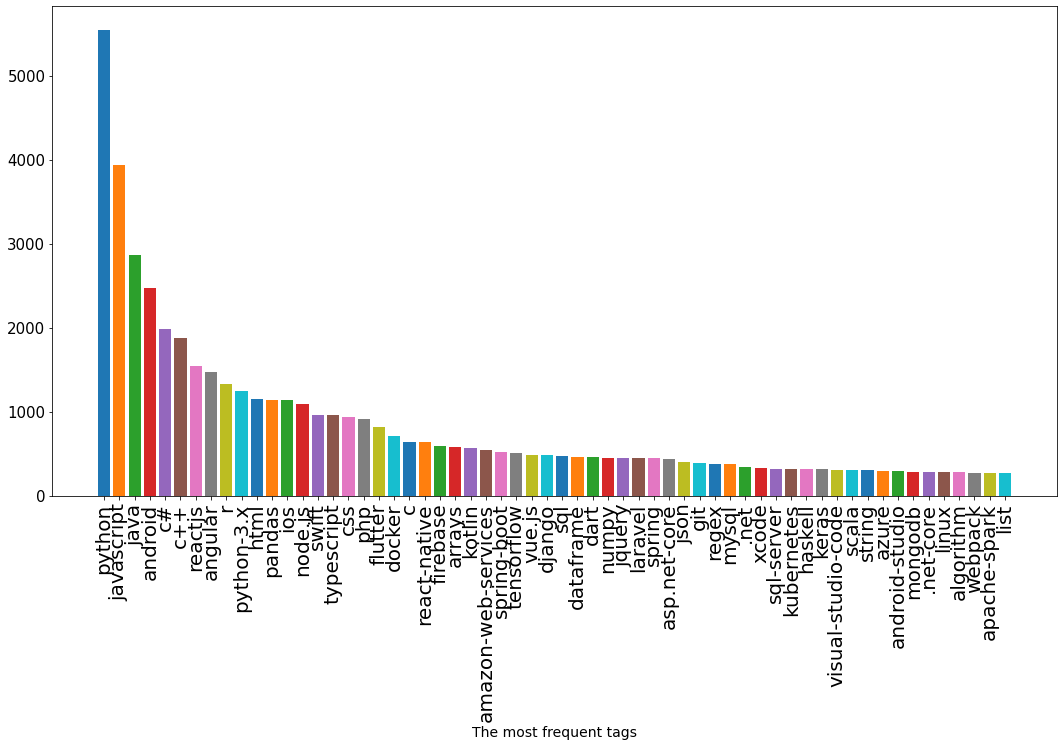

In [258]:
fig, ax = plt.subplots(figsize=(18, 9))


ax.set_xlabel('The most frequent tags', fontsize=14)
ax.bar(x=np.arange(60), 
       height=[x[1] for x in tag_count.most_common(60)],
       tick_label=[x[0] for x in tag_count.most_common(60)],
       color=plt.cm.get_cmap('tab10').colors)

plt.yticks(size=15)
plt.xticks(rotation='vertical', size=20)
plt.show()

In [259]:
def ListeToString(s):
  str1 = " "
  return (str1.join(s))

In [260]:
df_sample['Tag_st'] = df_sample['Tags'].apply(ListeToString)


In [261]:
df_sample.head()

,Title_Body,Title_Body_Tokens,Tags,Tag_st
0,create tray icon webdings font trying create s...,"[create, tray, icon, webdings, font, trying, c...","[c#, .net, windows, icons]",c# .net windows icons
1,intent basic execution p5 sentence 2 basic exe...,"[intent, basic, execution, sentence, basic, ex...","[c++, language-lawyer, full-expression]",c++ language-lawyer full-expression
2,mongodb reduce array objects single object com...,"[mongodb, reduce, array, object, single, objec...","[mongodb, mongodb-query, aggregation-framework]",mongodb mongodb-query aggregation-framework
3,laravel validate array objects wonder possible...,"[laravel, validate, array, object, wonder, pos...",[laravel],laravel
4,valueerror unknown activation function swish a...,"[valueerror, unknown, activation, function, sw...","[python, tensorflow, keras, activation-function]",python tensorflow keras activation-function


In [262]:
df_sample = df_sample[['Title_Body', 'Tag_st', 'Title_Body_Tokens', 'Tags']]
df_sample.head()

,Title_Body,Tag_st,Title_Body_Tokens,Tags
0,create tray icon webdings font trying create s...,c# .net windows icons,"[create, tray, icon, webdings, font, trying, c...","[c#, .net, windows, icons]"
1,intent basic execution p5 sentence 2 basic exe...,c++ language-lawyer full-expression,"[intent, basic, execution, sentence, basic, ex...","[c++, language-lawyer, full-expression]"
2,mongodb reduce array objects single object com...,mongodb mongodb-query aggregation-framework,"[mongodb, reduce, array, object, single, objec...","[mongodb, mongodb-query, aggregation-framework]"
3,laravel validate array objects wonder possible...,laravel,"[laravel, validate, array, object, wonder, pos...",[laravel]
4,valueerror unknown activation function swish a...,python tensorflow keras activation-function,"[valueerror, unknown, activation, function, sw...","[python, tensorflow, keras, activation-function]"


In [263]:
tags1 = df_sample['Tag_st']
questions1  = df_sample['Title_Body']

In [264]:
tags1

0                              c# .net windows icons
1                c++ language-lawyer full-expression
2        mongodb mongodb-query aggregation-framework
3                                            laravel
4        python tensorflow keras activation-function
                            ...                     
39995                   java multithreading for-loop
39996               python .net dll nuget python.net
39997                     angular typescript jasmine
39998                                         python
39999                    android android-databinding
Name: Tag_st, Length: 40000, dtype: object

In [265]:
questions1.head()

0    create tray icon webdings font trying create s...
1    intent basic execution p5 sentence 2 basic exe...
2    mongodb reduce array objects single object com...
3    laravel validate array objects wonder possible...
4    valueerror unknown activation function swish a...
Name: Title_Body, dtype: object

## **TF-IDF**

In [266]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [267]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words = stop_words, max_features=500)
X_tfidf = vectorizer.fit_transform(questions1).toarray()
#X_train_tfidf = vectorizer.fit_transform(X_train).toarray() 
#X_test_tfidf = vectorizer.fit_transform(X_test).toarray()
#print('Total words: ', len(vectorizer.vocabulary))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [268]:
print(X_tfidf.shape)

(40000, 500)


In [269]:
print(vectorizer.get_feature_names())

['able', 'access', 'account', 'action', 'activity', 'add', 'added', 'adding', 'address', 'amp', 'android', 'angular', 'answer', 'apache', 'api', 'app', 'append', 'application', 'apply', 'args', 'argument', 'array', 'async', 'attribute', 'auth', 'auto', 'available', 'await', 'aws', 'b', 'background', 'bar', 'base', 'based', 'better', 'bin', 'bit', 'block', 'body', 'boot', 'box', 'browser', 'build', 'builder', 'bundle', 'button', 'byte', 'c', 'cache', 'called', 'case', 'catch', 'category', 'cell', 'center', 'change', 'char', 'character', 'check', 'child', 'chrome', 'class', 'click', 'client', 'close', 'code', 'col', 'collection', 'color', 'column', 'com', 'command', 'common', 'compile', 'compiler', 'component', 'config', 'configuration', 'connect', 'connection', 'console', 'const', 'constructor', 'container', 'contains', 'content', 'context', 'control', 'controller', 'convert', 'copy', 'core', 'correct', 'count', 'create', 'created', 'creating', 'cs', 'csv', 'current', 'currently', 'cust

In [270]:
vectorizer.vocabulary_.items()

dict_items([('create', 94), ('icon', 198), ('font', 168), ('trying', 456), ('simple', 397), ('n', 283), ('currently', 100), ('end', 135), ('got', 181), ('static', 414), ('color', 68), ('new', 290), ('return', 366), ('try', 455), ('look', 262), ('better', 34), ('way', 484), ('intent', 220), ('execution', 146), ('state', 413), ('defined', 112), ('function', 175), ('use', 465), ('order', 306), ('sure', 430), ('apply', 18), ('change', 55), ('code', 65), ('example', 143), ('struct', 423), ('const', 81), ('amp', 9), ('f', 151), ('array', 21), ('object', 300), ('single', 398), ('field', 156), ('api', 14), ('data', 103), ('result', 365), ('format', 171), ('foo', 169), ('bar', 31), ('date', 106), ('fine', 161), ('like', 250), ('following', 167), ('problem', 331), ('key', 235), ('added', 6), ('query', 343), ('time', 447), ('want', 482), ('value', 472), ('know', 236), ('operator', 304), ('figure', 157), ('help', 192), ('possible', 327), ('form', 170), ('looking', 263), ('page', 312), ('vue', 480)

### **TF-IDF Weights**

In [271]:
#get word frequencies and create wordcloud
#tfidf_weights = [(word, X_tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

In [272]:
#type(tfidf_weights)

In [273]:
#tfidf_weights[0:10]

In [274]:
import pickle

#with open("list_tfidf_weights.txt", "wb") as fp:  #Pickling
  #pickle.dump(tfidf_weights , fp)

In [275]:
#with open("list_tfidf_weights.txt", "rb") as fp: # Unpickling
  #list_tfidf_weights = pickle.load(fp)
list_tfidf_weights = pd.read_pickle("/content/drive/My Drive/CentraleSupelec_OCR/P6/list_tfidf_weights.txt")
list_tfidf_weights[0:10]

[('create', 511.3767960970198),
 ('icon', 170.584933798478),
 ('font', 133.28881208560347),
 ('trying', 516.3588643418711),
 ('simple', 228.72724556382434),
 ('n', 506.86472992939),
 ('currently', 191.36114656785395),
 ('end', 377.8939002531042),
 ('got', 208.30616622812857),
 ('static', 283.4109168413933)]

### **WordCloud**

In [276]:
from wordcloud import WordCloud
w = WordCloud(width=1500,height=1200,mode='RGBA',background_color='white',max_words=500).fit_words(dict(list_tfidf_weights))

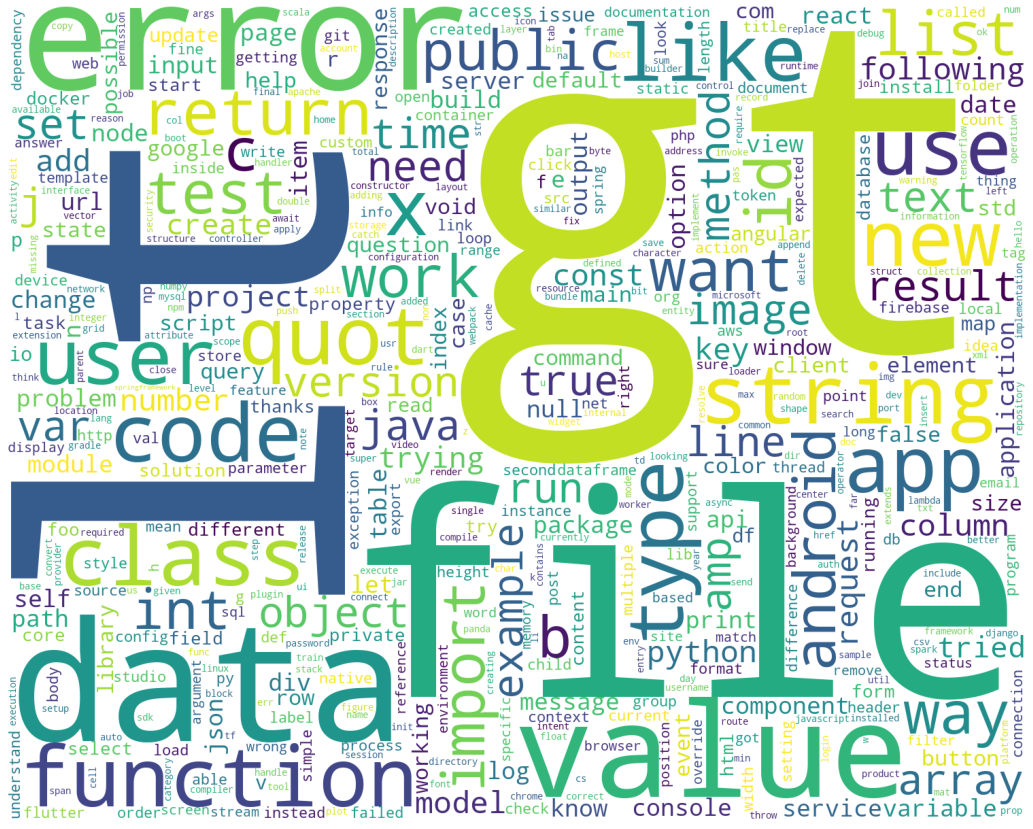

In [277]:
# all below in a single cell
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('recipes_wordcloud.png')

In [278]:
X_tfidf = pd.DataFrame(X_tfidf)
X_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111389,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.064769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.126769,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.331607,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.083650,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.080473,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.069312,0.0,0.0,0.0,0.000000,0.0,0.0,0.210857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464138,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.133332,0.000000,0.0,0.000000,0.0,0.0,0.0,0.050871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.047213,0.0,0.049338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.074068,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.175850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.071794,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136742,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.101146,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [279]:
questions_value = vectorizer.vocabulary_

In [280]:
questions_value_df = pd.DataFrame(questions_value.items(), columns=['word', 'value'])
questions_value_df.head()


,word,value
0,create,94
1,icon,198
2,font,168
3,trying,456
4,simple,397


In [281]:
word_list = questions_value_df['word'].to_list()
X_tfidf.columns = word_list
X_tfidf.head()

,create,icon,font,trying,simple,n,currently,end,got,static,color,new,return,try,look,better,way,intent,execution,state,defined,function,use,order,sure,apply,change,code,example,struct,const,amp,f,array,object,single,field,api,data,result,...,day,hello,std,implementation,webpack,entry,join,loader,port,us,token,folder,device,answer,convert,runtime,interface,entity,password,extension,screen,permission,h,username,structure,cache,insert,char,double,video,record,npm,springframework,docker,scala,provider,li,spark,category,na
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111389,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.064769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.126769,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.331607,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.083650,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.080473,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.069312,0.0,0.0,0.0,0.000000,0.0,0.0,0.210857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464138,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.133332,0.000000,0.0,0.000000,0.0,0.0,0.0,0.050871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.047213,0.0,0.049338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.074068,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.175850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.071794,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136742,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.101146,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [283]:
temp = df_sample[['Title_Body']]
X_tfidf = pd.concat([temp, X_tfidf], axis=1 )
X_tfidf.head()

,Title_Body,Title_Body,create,icon,font,trying,simple,n,currently,end,got,static,color,new,return,try,look,better,way,intent,execution,state,defined,function,use,order,sure,apply,change,code,example,struct,const,amp,f,array,object,single,field,api,...,day,hello,std,implementation,webpack,entry,join,loader,port,us,token,folder,device,answer,convert,runtime,interface,entity,password,extension,screen,permission,h,username,structure,cache,insert,char,double,video,record,npm,springframework,docker,scala,provider,li,spark,category,na
0,create tray icon webdings font trying create s...,create tray icon webdings font trying create s...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111389,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.064769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,intent basic execution p5 sentence 2 basic exe...,intent basic execution p5 sentence 2 basic exe...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.126769,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.331607,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.083650,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,mongodb reduce array objects single object com...,mongodb reduce array objects single object com...,0.0,0.0,0.0,0.0,0.0,0.000000,0.080473,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.069312,0.0,0.0,0.0,0.000000,0.0,0.0,0.210857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464138,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.133332,0.000000,0.0,0.000000,0.0,0.0,0.0,0.050871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.047213,0.0,0.049338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,laravel validate array objects wonder possible...,laravel validate array objects wonder possible...,0.0,0.0,0.0,0.0,0.0,0.074068,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.175850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.071794,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136742,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,valueerror unknown activation function swish a...,valueerror unknown activation function swish a...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.101146,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [287]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=sorted(dict_tag_500.keys()))
df_tags_num = mlb.fit_transform(df_sample['Tags'])


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['.app', '.htaccess', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6', '.net-4.6.1', '.net-4.7.1', '.net-4.7.2', '.net-assembly', '.net-attributes', '.net-core-1.1', '.net-core-2.0', '.net-core-2.1', '.net-core-2.2', '.net-core-3.0', '.net-core-3.1', '.net-core-configuration', '.net-core-publishsinglefile', '.net-framework-version', '.net-standard', '.net-standard-2.0', '.net-standard-2.1', '.so', '2-way-object-databinding', '2checkout', '2d', '2d-games', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-model', '3d-secure', '3dcamera', '64-bit', '6502', '68000', '7zip', 'a-star', 'a2dp', 'aac', 'aapt', 'aapt2', 'aar', 'abac', 'abap', 'abc', 'abcl', 'abi', 'abseil', 'absinthe', 'abstract', 'abstract-class', 'abstract-interpretation', 'abstract-syntax-tree', 'abstraction', 'accelerate', 'accelerate-haskell', 'accelerated-mobile-page', 'access-control', 'access-denied', 'access-levels', '

In [288]:
df_tags_num.shape

(40000, 500)

In [289]:
df_tags_num

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [290]:
mlb.classes_

array(['.net', '.net-core', 'aggregation-framework', 'airflow', 'ajax',
       'algorithm', 'amazon-cloudformation', 'amazon-cognito',
       'amazon-dynamodb', 'amazon-ec2', 'amazon-s3',
       'amazon-web-services', 'anaconda', 'android',
       'android-architecture-components', 'android-constraintlayout',
       'android-fragments', 'android-gradle-plugin', 'android-jetpack',
       'android-layout', 'android-livedata', 'android-recyclerview',
       'android-room', 'android-studio', 'androidx', 'angular',
       'angular-cli', 'angular-material', 'angular-material2', 'angular5',
       'angular6', 'angular7', 'angularjs', 'animation', 'annotations',
       'ansible', 'apache', 'apache-kafka', 'apache-spark',
       'apache-spark-sql', 'api', 'apollo', 'arkit', 'arm', 'arraylist',
       'arrays', 'asp.net', 'asp.net-core', 'asp.net-core-2.0',
       'asp.net-core-2.1', 'asp.net-core-mvc', 'asp.net-core-webapi',
       'asp.net-mvc', 'asp.net-web-api', 'assembly', 'async-await',
  

In [ ]:
pd.DataFrame(mlb.fit_transform(df['Genres_relevant']), columns=mlb.classes_, 
         index=df.index)

In [291]:
df = pd.DataFrame(df_tags_num, columns=mlb.classes_)
df


,.net,.net-core,aggregation-framework,airflow,ajax,algorithm,amazon-cloudformation,amazon-cognito,amazon-dynamodb,amazon-ec2,amazon-s3,amazon-web-services,anaconda,android,android-architecture-components,android-constraintlayout,android-fragments,android-gradle-plugin,android-jetpack,android-layout,android-livedata,android-recyclerview,android-room,android-studio,androidx,angular,angular-cli,angular-material,angular-material2,angular5,angular6,angular7,angularjs,animation,annotations,ansible,apache,apache-kafka,apache-spark,apache-spark-sql,...,variables,vb.net,vba,vector,vectorization,video,vim,visual-c++,visual-studio,visual-studio-2017,visual-studio-2019,visual-studio-code,vscode-settings,vue-component,vue.js,vuejs2,vuetify.js,vuex,web,web-scraping,webpack,websocket,webview,winapi,windows,windows-10,winforms,woocommerce,wordpress,wpf,x86,xamarin,xamarin.android,xamarin.forms,xaml,xcode,xcode11,xml,yaml,yarnpkg
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
'''ohe_enc = OneHotCategoricalEncoder(
    top_categories=500,
    variables=['Tag_st'],
    drop_last=False)
df_tags_num = ohe_enc.fit_transform(df_sample)
df_tags_num = df_tags_num.drop(['Title_Body',	'Title_Body_Tokens', 'Tags'], axis=1)
df_tags_num.head()

,Tag_st_python pandas,Tag_st_python,Tag_st_javascript,Tag_st_c++,Tag_st_r,Tag_st_python pandas dataframe,Tag_st_java,Tag_st_dart flutter,Tag_st_javascript reactjs,Tag_st_typescript,Tag_st_flutter,Tag_st_python python-3.x,Tag_st_angular,Tag_st_html css,Tag_st_android,Tag_st_react-native,Tag_st_c#,Tag_st_angular typescript,Tag_st_r dplyr,Tag_st_haskell,Tag_st_sql sql-server,Tag_st_git,Tag_st_r ggplot2,Tag_st_reactjs,Tag_st_javascript jquery,Tag_st_javascript html,Tag_st_python numpy,Tag_st_java java-8 java-stream,Tag_st_c,Tag_st_rust,Tag_st_kotlin,Tag_st_julia,Tag_st_php laravel,Tag_st_javascript html css,Tag_st_visual-studio-code,Tag_st_flutter dart,Tag_st_python tensorflow,Tag_st_excel vba,Tag_st_go,Tag_st_python django,...,Tag_st_java android firebase firebase-realtime-database,Tag_st_r dataframe dplyr,Tag_st_php composer-php,Tag_st_android kotlin android-room,Tag_st_javascript html jquery css,Tag_st_angular angular-forms,Tag_st_wordpress,Tag_st_html angular typescript,Tag_st_c++ algorithm,Tag_st_google-cloud-platform google-compute-engine,Tag_st_python regex python-3.x,Tag_st_python csv,Tag_st_javascript puppeteer,Tag_st_r rstudio,Tag_st_sql sql-server tsql,Tag_st_java android kotlin,Tag_st_c# json json.net,Tag_st_javascript vue.js vuetify.js,Tag_st_python algorithm,Tag_st_html css html-table,Tag_st_jquery html css,Tag_st_c++ reference,Tag_st_python pandas csv dataframe,Tag_st_awk,Tag_st_google-app-engine google-cloud-platform,Tag_st_admin-on-rest react-admin,Tag_st_amazon-web-services aws-glue,Tag_st_javascript webpack,Tag_st_haskell functional-programming,Tag_st_azure azure-web-app-service,Tag_st_google-bigquery,Tag_st_git git-lfs,Tag_st_c pointers,Tag_st_lua,Tag_st_swift codable,Tag_st_c++ multithreading,Tag_st_angular angular-material angular-material2,Tag_st_r shiny shinydashboard,Tag_st_android android-studio gradle android-gradle-plugin build.gradle,Tag_st_apache-nifi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_tfidf.to_csv('X_tfidf_500.csv')
#df_tags_num.to_csv('y_onehot.csv')
df_tags_num.to_csv('y_onehot_500.csv')